# Task - 3

In [1]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345


from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit import CircuitInstruction
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute


In [2]:
# loading the iris and splitting it into train and test data

iris_data = load_iris()

features = iris_data.data
features = MinMaxScaler().fit_transform(features) #normalisation

labels = iris_data.target

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [3]:
num_features = features.shape[1]
iris_feature_map = PauliFeatureMap(feature_dimension=num_features, reps=1,entanglement='linear',paulis=['ZZ']) # specifying the feature map

sampler = Sampler() # qiskit sampler primitive is evaluate the kernel function

fidelity = ComputeUncompute(sampler=sampler)

iris_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=iris_feature_map)

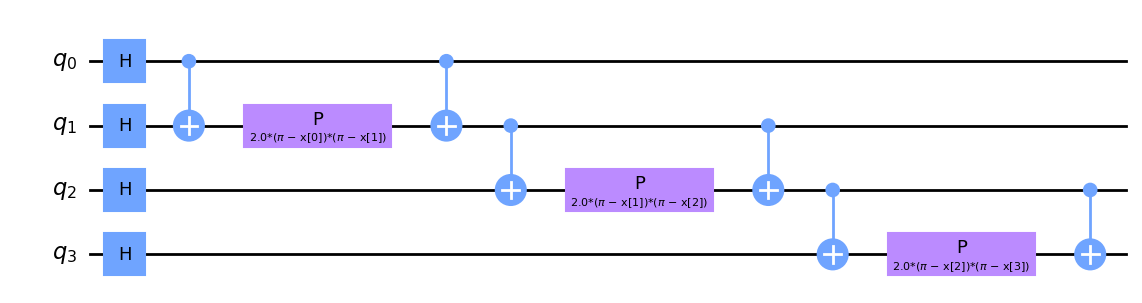

In [4]:
iris_feature_map.decompose().draw(output='mpl',fold=20)

In [5]:
qsvc = QSVC(quantum_kernel=iris_kernel)

result = qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.9666666666666667


# Reducing the number of qubits using Principal Component Analysis

Inorder to decrease the number of qubits, classical PCA algorithm is applied to decrease number of features from four to two. It will subsequently reduce the number of qubits

In [6]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [7]:
num_features = features.shape[1]
iris_feature_map = PauliFeatureMap(feature_dimension = num_features,reps=1,entanglement='linear',paulis=['ZZ'])

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

iris_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=iris_feature_map)

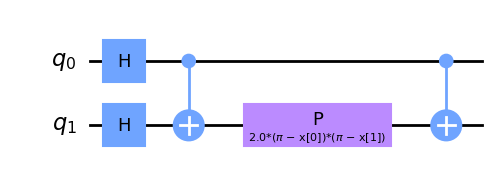

In [8]:
iris_feature_map.decompose().draw(output='mpl',fold=20)

In [9]:
qsvc = QSVC(quantum_kernel=iris_kernel)

result = qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.4666666666666667


## Custom Quantum Kernel using $UU^{\dagger}$ method

Here we are defining a custom quantum kernel using PaulifeatureMap where we calculate kernel matrix using $UU^{\dagger}$ method. Now, this custom quantum kernel can be used in SVC module (from scikit.learn) in two ways:

        1. by providing the kernel as a callable function
        2. by pre-computing the kernel matrix

In [10]:
from sklearn.svm import SVC
from qiskit import opflow, Aer
from qiskit_machine_learning.kernels import QuantumKernel

In [11]:
# Loading data set and splitting it into train and test data

iris_data = load_iris()

features = iris_data.data
features = MinMaxScaler().fit_transform(features) #normalisation

labels = iris_data.target

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


### Pre-Computing the Kernel Matrix

In [12]:
# Defining function to calculate Quantum Kernel

def calculate_kernel(feature_map, x_data, y_data=None):
    """
        Calculates  kernel matrix from provided feature map and
        dataset(s), x & (y). If y isn't given, self inner product
        of x is calculated.
    """
    if y_data is None:
        y_data = x_data
    # Use Operator Flow to create a list of feature map circuits,
    # parameterized by each data point
    x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(x_data).tolist()))
        )
    y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(y_data).tolist()))
        )
    # Compute the square of the conjugate inner product of the feature
    # map circuits: the kernel matrix
    kernel = np.abs(
        (~y_circuits.to_matrix_op() @ x_circuits.to_matrix_op()).eval()
    )**2
    return kernel

In [13]:
num_features = features.shape[1]
iris_feature_map = PauliFeatureMap(feature_dimension=4, reps=1,entanglement ='linear', paulis = ['ZZ'],insert_barriers=True)
iris_kernel = calculate_kernel(iris_feature_map,train_features)

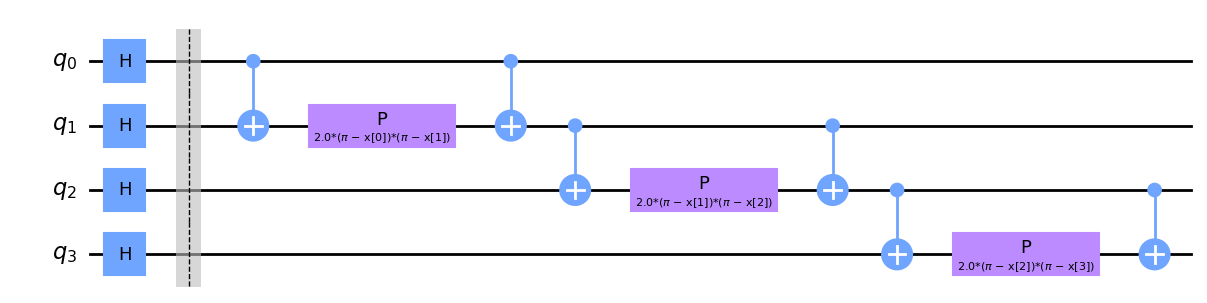

In [14]:
iris_feature_map.decompose().draw(output='mpl',fold=20)

In [15]:
train_kernel = calculate_kernel(iris_feature_map, train_features)
test_kernel = calculate_kernel(iris_feature_map, train_features, test_features)

In [16]:

# train scikit-learn svm model
model = SVC(kernel='precomputed')
model.fit(train_kernel, train_labels)
model.score(test_kernel, test_labels)

0.9666666666666667

## Providing Kernel as a callable function

In [17]:
from qiskit import Aer
from qiskit_machine_learning.kernels import QuantumKernel
# Create the quantum feature map
adhoc_feature_map = PauliFeatureMap(feature_dimension=num_features,
                                 reps=1,
                                 entanglement='linear',paulis=['Z'])
# Create the quantum kernel
iris_kernel = QuantumKernel(feature_map=iris_feature_map,
                             quantum_instance=Aer.get_backend(
                                             'aer_simulator_statevector'))

# Set the SVC algorithm to use our custom kernel
iris_svc = SVC(kernel=iris_kernel.evaluate)
iris_svc.fit(train_features, train_labels)
iris_svc.score(test_features, test_labels)

0.9666666666666667

Compared to qiskit's `FidelityQuantumKernel`, the custom kernel along with the classical SVC found to take less execution time. A lot of trails by chaning the *paulis* parameter in the `PauliFeatureMap` was conducted and found that maximum score that can be attained to have an upper bound of **0.9667**. 

**References**

 1.  **[Variational Quantum Classifier-Qiskit Tutorial](https://qiskit.org/documentation/machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html)**
 2.  **[PauliFeatureMap - Qiskit Documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html#qiskit.circuit.library.PauliFeatureMap)**
 3.  **[Quantum Kernel Methods - Qiskit Tutorial](https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/03_quantum_kernel.ipynb)**
 4.  **[Quantum Machine Learnig - Qiskit Textbook](https://learn.qiskit.org/course/machine-learning/introduction)**
